# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

from benchmarks.generator import get_revenue_behavior_deprecated
from benchmarks.utils import int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart

from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Supply

from pathlib import Path
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(output_path=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

     Number of Services
RU2                   3
RU3                   7
RU1                   5
RU4                   5
RU5                   5


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = list(supply.lines)
line = infer_line_stations(lines)

Services:  25


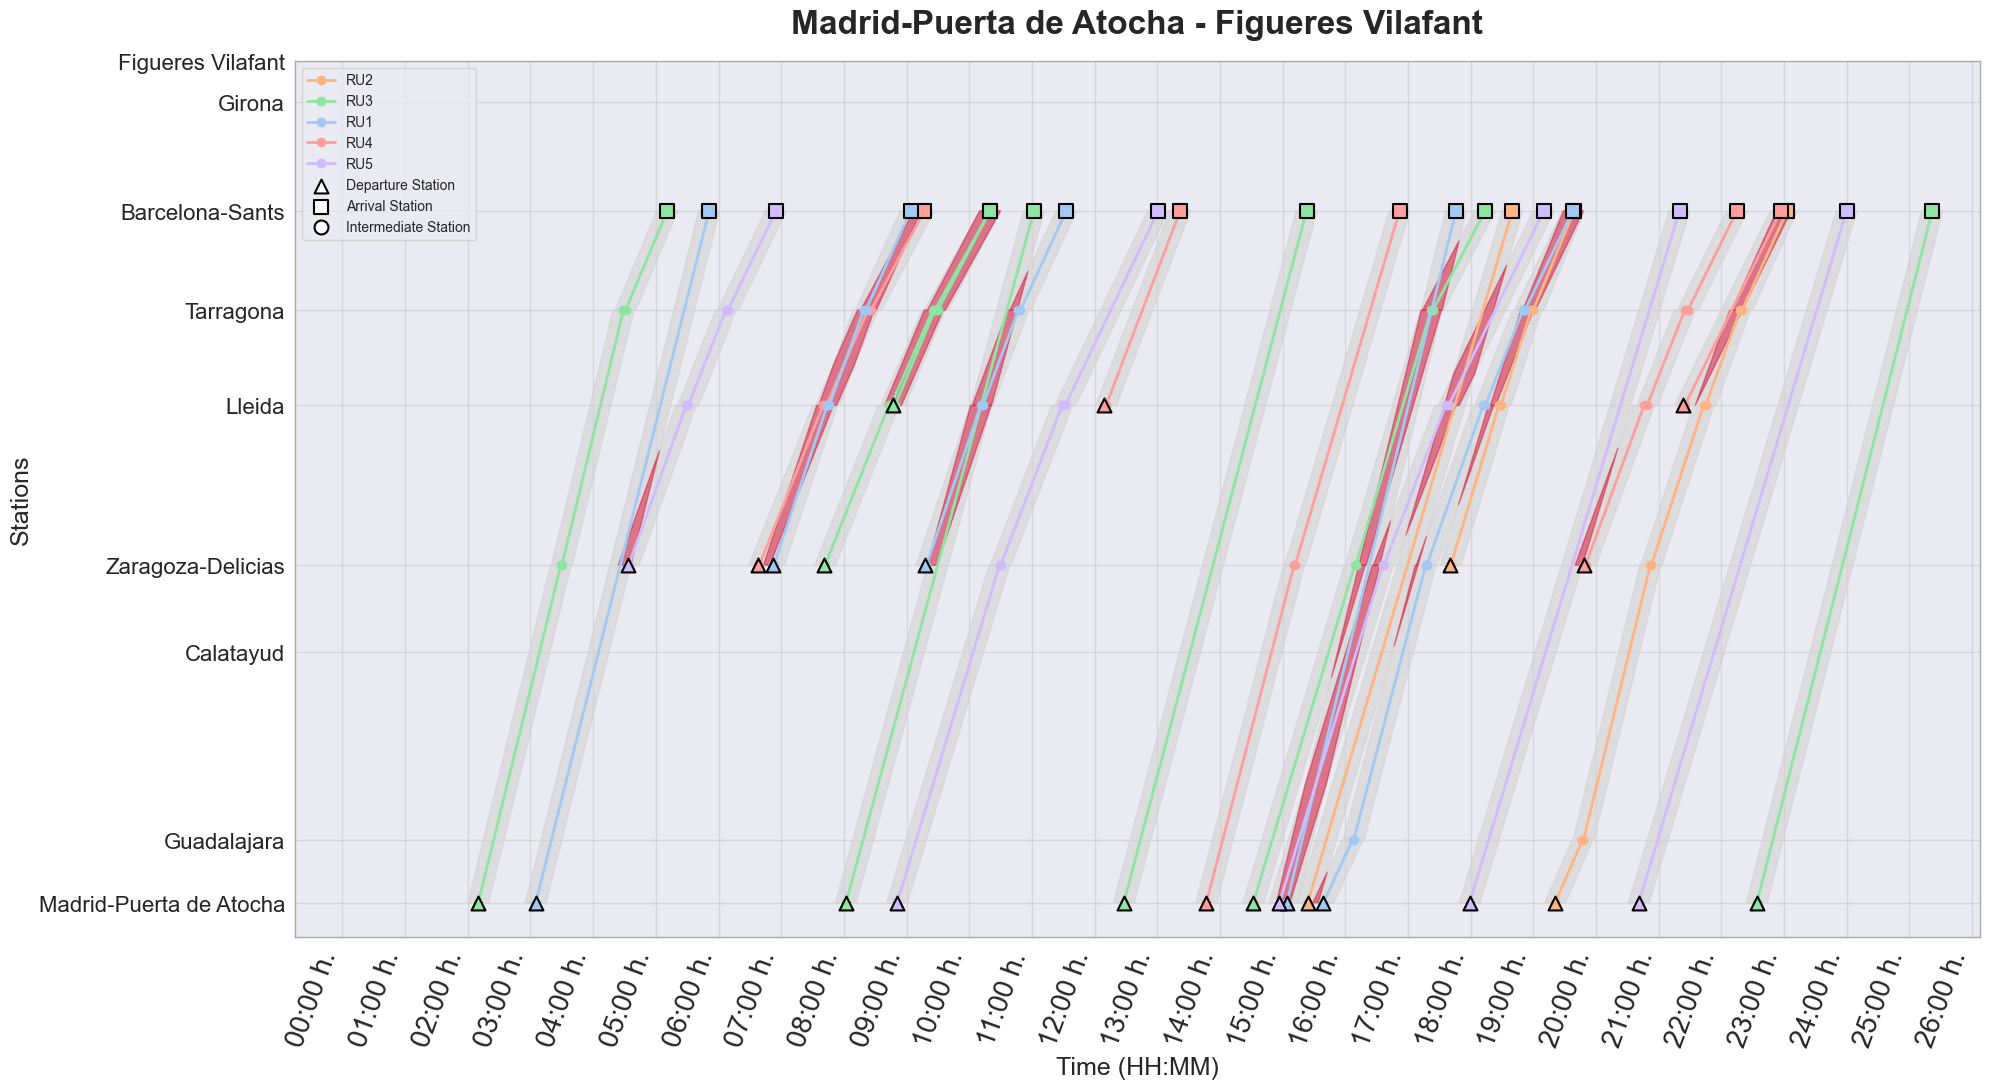

In [6]:
import datetime

date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=supply,
    date=date,
    save_path='../figures/escim2025/'
)

## 1. Pyomo

In [7]:
from src.timetabling_problem import MPTT

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10
)

In [8]:
travel_times = {}
dwell_times = {}
lower_bounds = {}
upper_bounds = {}
for service in supply.services:
    for i, (station, (arrival, departure)) in enumerate(service.schedule.items()):
        if len(service.schedule) > 1 and i == len(service.schedule) - 1:
            break
        travel_times[(service.id, i)] = (tuple(service.schedule.values())[i+1][0] - departure).total_seconds() / 60
        dwell_times[(service.id, i)] = (departure - arrival).total_seconds() / 60
        lower_bounds[(service.id, i)] = departure.total_seconds() // 60 - 60
        upper_bounds[(service.id, i)] = departure.total_seconds() // 60 + 60

In [9]:
def bounds_schedule_times(model, service, station):
    return (lower_bounds[(service, station)], upper_bounds[(service, station)])

In [27]:
import pyomo.environ as pyo

from math import e, pi

IM_BOUND = 60

model = pyo.ConcreteModel()

service_station_idx = list(travel_times.keys())
services_names = list(dict.fromkeys(mptt.service_indexer))

model.requests = pyo.Set(initialize=service_station_idx, dimen=2)
model.schedule_times = pyo.Var(model.requests, within=pyo.NonNegativeReals, bounds=bounds_schedule_times)
model.is_scheduled = pyo.Var(services_names, within=pyo.Binary)

model.travel_times = pyo.Param(model.requests, initialize=travel_times, within=pyo.NonNegativeReals)
model.dwell_times = pyo.Param(model.requests, initialize=dwell_times, within=pyo.NonNegativeReals)


def penalty_function(x: float, k: float) -> float:
    """
    Calculate the penalty function based on the given parameters.

    Args:
        x (float): Normalized deviation from the ideal schedule time.
        k (float): Penalty factor that influences the steepness of the penalty curve.

    Returns:
        float: The penalty value calculated using the formula.
    """
    return 1 - e ** (-k * x ** 2) * (0.5 * pyo.cos(pi * x) + 0.5)


def departure_time_penalty(model: pyo.ConcreteModel, service: str, im_bound: int = IM_BOUND) -> float:
    """
    Calculate the penalty for the departure time of a service.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times.
        service (str): Service ID for which the penalty is calculated.
        im_bound (int): Maximum allowed deviation in minutes (default is 60).

    Returns:
        float: Penalty value based on the departure time deviation.
    """
    alpha = penalty_function(
        x = (model.schedule_times[(service, 0)] - list(mptt.requested_schedule[service].values())[0][1]) / im_bound,
        k = revenue_behavior[service]['k']
    )
    return alpha * revenue_behavior[service]['dt_max_penalty']

def travel_time_penalty(model: pyo.ConcreteModel, service: str, im_bound: int = IM_BOUND) -> float:
    """
    Calculate the penalty for the travel time of a service.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times.
        service (str): Service ID for which the penalty is calculated.
        im_bound (int): Maximum allowed deviation in minutes (default is 60).

    Returns:
        float: Penalty value based on the travel time deviation.
    """
    total_travel_time_penalty = 0.0
    for j in range(len(mptt.requested_schedule[service]) - 2):
        updated_travel_time = model.schedule_times[(service, j+1)] - model.schedule_times[(service, j)] - model.dwell_times[(service, j)]
        beta = penalty_function(
            x=(updated_travel_time - model.travel_times[(service, j)]) / im_bound,
            k=revenue_behavior[service]['k']
        )
        total_travel_time_penalty += beta * revenue_behavior[service]['tt_max_penalty']
    return total_travel_time_penalty

@model.Objective(sense=pyo.maximize)
def objective_function(model):
    return sum(
        model.is_scheduled[service_id] * (revenue_behavior[service_id]['canon'] * (1 - departure_time_penalty(model, service_id) - travel_time_penalty(model, service_id)))
        for service_id in services_names
    )

def departure_time_rule(model, service, j):
    if j == 0:
        return pyo.Constraint.Skip
    return (
        model.schedule_times[(service, j)] * model.is_scheduled[service]
        >= (model.schedule_times[(service, j-1)]
           + model.travel_times[(service, j-1)]
           + model.dwell_times[(service, j)]) * model.is_scheduled[service]
    )

model.departure_time_restriction = pyo.Constraint(model.requests, rule=departure_time_rule)

In [28]:
solver = pyo.SolverFactory('scip')
solver.options['limits/time'] = 30
result_obj = solver.solve(model, tee=True)

SCIP version 9.2.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 7.1.3] [GitHash: 416226a4f8]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  Readline 8.2         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 7.1.3         Linear programming solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 60fd96f2]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.2.12          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.3.0            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.1         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB)
  Nauty 2.8.8          Computing Graph Automorphism Groups by Brendan D. McKay (users.cecs.an

In [29]:
model.pprint()

1 Set Declarations
    requests : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :   57 : {('0_2025-06-25-17.40', 0), ('0_2025-06-25-17.40', 1), ('0_2025-06-25-17.40', 2), ('1_2025-06-25-14.32', 0), ('1_2025-06-25-14.32', 1), ('1_2025-06-25-14.32', 2), ('2_2025-06-25-15.04', 0), ('3_2025-06-25-13.47', 0), ('3_2025-06-25-13.47', 1), ('4_2025-06-25-22.34', 0), ('5_2025-06-25-12.09', 0), ('6_2025-06-25-2.10', 0), ('6_2025-06-25-2.10', 1), ('6_2025-06-25-2.10', 2), ('7_2025-06-25-8.02', 0), ('8_2025-06-25-8.51', 0), ('8_2025-06-25-8.51', 1), ('8_2025-06-25-8.51', 2), ('9_2025-06-25-15.24', 0), ('10_2025-06-25-12.28', 0), ('11_2025-06-25-3.05', 0), ('12_2025-06-25-6.38', 0), ('12_2025-06-25-6.38', 1), ('12_2025-06-25-6.38', 2), ('13_2025-06-25-15.39', 0), ('13_2025-06-25-15.39', 1), ('13_2025-06-25-15.39', 2), ('13_2025-06-25-15.39', 3), ('13_2025-06-25-15.39', 4), ('14_2025-06-25-19.21', 0), ('14_2025-06-25-19.21', 1), ('1

In [31]:
pyo.value(model.objective_function)

5020.897122875104

In [33]:
max_revenue = sum([mptt.revenue[service]['canon'] for service in mptt.revenue])
max_revenue

5824.5